## 이변량 관계의 이상값과 예상치 못한 값
- 이변량 관계의 이상값 : 관심있는 변수가 다른 변수와 유의한 상관관계가 있을 때에 그 관계를 고려하여 이상값을 식별하거나 통계 분석을 수행해야 함
- 예상치 못한 값

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
covidtotals = pd.read_csv('./data/covidtotals.csv')
covidtotals.set_index('iso_code', inplace = True)

totvars = ['location', 'total_cases', 'total_deaths',
       'total_cases_pm', 'total_deaths_pm']

demovars = ['population', 'pop_density',
       'median_age', 'gdp_per_capita', 'hosp_beds']

In [9]:
covidtotals.head()

,lastdate,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
iso_code,,,,,,,,,,,
AFG,2020-06-01,Afghanistan,15205,257,390.589,6.602,38928341.0,54.422,18.6,1803.987,0.50
ALB,2020-06-01,Albania,1137,33,395.093,11.467,2877800.0,104.871,38.0,11803.431,2.89
DZA,2020-06-01,Algeria,9394,653,214.225,14.891,43851043.0,17.348,29.1,13913.839,1.90
AND,2020-06-01,Andorra,764,51,9888.048,660.066,77265.0,163.755,NaN,NaN,NaN
AGO,2020-06-01,Angola,86,4,2.617,0.122,32866268.0,23.890,16.8,5819.495,NaN


### 1. 누적 및 인구통계 열에 대한 상관행렬(crosstab)
    - 총확진자 수 & 사망자 수 : 매우 높음(0.93)
    - 백만 명당 총확진자 수 & 백만 명당 총사망자 수 : 상당한 상관관계(0.59)
    - 1인당 국민소득 & 백만 명당 확진자 수 : 강한 상관관계(0.66)

In [10]:
covidtotals.corr(method = 'pearson')

,total_cases,total_deaths,total_cases_pm,total_deaths_pm,population,pop_density,median_age,gdp_per_capita,hosp_beds
total_cases,1.000000,0.932079,0.181851,0.247183,0.270030,-0.028737,0.162698,0.186835,0.027601
total_deaths,0.932079,1.000000,0.179440,0.394614,0.212619,-0.031645,0.205128,0.198729,0.019990
total_cases_pm,0.181851,0.179440,1.000000,0.586098,-0.056564,0.127174,0.320626,0.662983,0.081449
total_deaths_pm,0.247183,0.394614,0.586098,1.000000,-0.014291,0.040299,0.395619,0.391254,0.120488
population,0.270030,0.212619,-0.056564,-0.014291,1.000000,-0.023084,0.024395,-0.059555,-0.038329
pop_density,-0.028737,-0.031645,0.127174,0.040299,-0.023084,1.000000,0.178878,0.315199,0.314973
median_age,0.162698,0.205128,0.320626,0.395619,0.024395,0.178878,1.000000,0.648905,0.662222
gdp_per_capita,0.186835,0.198729,0.662983,0.391254,-0.059555,0.315199,0.648905,1.000000,0.296995
hosp_beds,0.027601,0.019990,0.081449,0.120488,-0.038329,0.314973,0.662222,0.296995,1.000000


- 총확진자 수에 비해 총 사망자 수가 예상을 벗어나는 국가가 있는지 확인

In [17]:
covidtotalsonly = covidtotals.loc[:, totvars]

covidtotalsonly['total_cases_q'] = pd.qcut(covidtotalsonly['total_cases'], q = 5, labels = ['very low', 'low', 'medium', 'high', 'very high'], precision = 0)
covidtotalsonly['total_deaths_q'] = pd.qcut(covidtotalsonly['total_deaths'], q = 5, labels = ['very low', 'low', 'medium', 'high', 'very high'], precision = 0)

In [18]:
covidtotalsonly.head(3)

,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm,total_cases_q,total_deaths_q
iso_code,,,,,,,
AFG,Afghanistan,15205,257,390.589,6.602,high,high
ALB,Albania,1137,33,395.093,11.467,medium,medium
DZA,Algeria,9394,653,214.225,14.891,high,very high


- crosstab 해석 : 대각선에 맞지 않는 국가들은 총확진자수가 높지만 총 사망자수가 중간인 경우

In [19]:
pd.crosstab(covidtotalsonly.total_cases_q, covidtotalsonly.total_deaths_q)

total_deaths_q,very low,low,medium,high,very high
total_cases_q,,,,,
very low,34,7,1,0,0
low,12,19,10,1,0
medium,1,13,15,13,0
high,0,0,12,24,6
very high,0,0,2,4,36


In [26]:
covidtotals.loc[(covidtotalsonly.total_cases_q == 'very high') & (covidtotalsonly.total_deaths_q == 'medium')].T

iso_code,QAT,SGP
lastdate,2020-06-01,2020-06-01
location,Qatar,Singapore
total_cases,56910,34884
total_deaths,38,23
total_cases_pm,19753.146,5962.727
total_deaths_pm,13.19,3.931
population,2881060.0,5850343.0
pop_density,227.322,7915.731
median_age,31.9,42.4
gdp_per_capita,116935.6,85535.383


- 확진자수가 낮으면서 사망자수가 높은 국가

In [25]:
covidtotals.loc[(covidtotalsonly.total_cases_q == 'low') & (covidtotalsonly.total_deaths_q == 'high')].T

iso_code,YEM
lastdate,2020-06-01
location,Yemen
total_cases,323
total_deaths,80
total_cases_pm,10.829
total_deaths_pm,2.682
population,29825968.0
pop_density,53.508
median_age,20.3
gdp_per_capita,1479.147


- 총 확진자수와 총 사망자 수 산점도

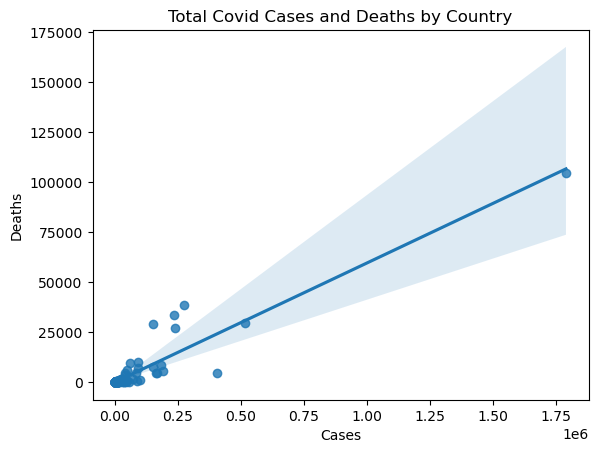

In [27]:
ax = sns.regplot(x = 'total_cases', y = 'total_deaths', data = covidtotals)
ax.set(xlabel = 'Cases', ylabel = 'Deaths', title = 'Total Covid Cases and Deaths by Country')
plt.show()

- 회귀 직선 위쪽&아래쪽의 예상치 못한 값 찾기

In [28]:
covidtotals.loc[(covidtotals.total_cases < 300000) & (covidtotals.total_deaths > 20000)].T

iso_code,FRA,ITA,ESP,GBR
lastdate,2020-06-01,2020-06-01,2020-05-31,2020-06-01
location,France,Italy,Spain,United Kingdom
total_cases,151753,233019,239429,274762
total_deaths,28802,33415,27127,38489
total_cases_pm,2324.879,3853.985,5120.952,4047.403
total_deaths_pm,441.251,552.663,580.197,566.965
population,65273512.0,60461828.0,46754783.0,67886004.0
pop_density,122.578,205.859,93.105,272.898
median_age,42.0,47.9,45.5,40.8
gdp_per_capita,38605.671,35220.084,34272.36,39753.244


In [29]:
covidtotals.loc[(covidtotals.total_cases > 300000) & (covidtotals.total_deaths < 10000)].T

iso_code,RUS
lastdate,2020-06-01
location,Russia
total_cases,405843
total_deaths,4693
total_cases_pm,2780.995
total_deaths_pm,32.158
population,145934460.0
pop_density,8.823
median_age,39.6
gdp_per_capita,24765.954


- 백만명당 확진자 수와 사망자 수를 산점도로 확인

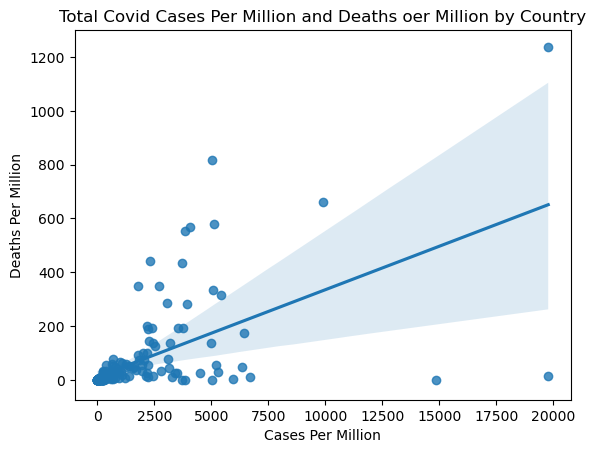

In [30]:
ax = sns.regplot(x = 'total_cases_pm', y = 'total_deaths_pm', data = covidtotals)
ax.set(xlabel = 'Cases Per Million', ylabel = 'Deaths Per Million', title = 'Total Covid Cases Per Million and Deaths oer Million by Country')
plt.show()